In [1]:
#import libraries

import os
import numpy as np
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Reshape, Multiply, Flatten, Dense, Dropout, Activation, BatchNormalization, Concatenate
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2

2023-12-12 19:16:46.077461: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 19:16:47.766146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# Data preparation
TRAIN_DIR = "Food/training_1/"
TEST_DIR= "Food/evaluation_1/"

im_shape = (250,250)
BATCH_SIZE=32
num_classes=11
seeds = 41

In [6]:
val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()

In [7]:
# Subdivision in test/validation
data_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,horizontal_flip=True,validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,horizontal_flip=True,validation_split=0.2)
test_generator = ImageDataGenerator(rescale=1./255)


# Generator of Train
train_generator = data_generator.flow_from_directory(TRAIN_DIR, target_size=im_shape, shuffle=True, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="training")
# Generator of validation
validation_generator = val_data_generator.flow_from_directory(TRAIN_DIR, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="validation")

# Generator of dataset test
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 10641 images belonging to 11 classes.
Found 2656 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.
Classes: ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']


# InceptionResNetV2

In [8]:
from tensorflow.keras.applications import InceptionResNetV2
# Load the pretrained model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

# Freeze the base model
base_model.trainable = False

# Add a global average pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

# Add a dense layer with 11 units and softmax activation for classification
output = tf.keras.layers.Dense(11, activation='softmax')(x)

# Create the model
model_3 = tf.keras.Model(inputs=base_model.input, outputs=output)

2023-12-12 19:17:12.186394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-12 19:17:12.282131: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-12 19:17:12.282418: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

219055592/219055592 [==============================] - 33s 0us/step


In [10]:
# Compile the model
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Train the model for 3 epochs
history_3 = model_3.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10


2023-12-12 19:18:05.406167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-12 19:18:07.606577: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-12 19:18:08.327140: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1e31d4f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-12 19:18:08.327170: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-12-12 19:18:08.436821: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  3/333 [..............................] - ETA: 10s - loss: 2.5098 - accuracy: 0.0833    

2023-12-12 19:18:08.905800: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


333/333 [==============================] - 29s 51ms/step - loss: 0.8381 - accuracy: 0.7225 - val_loss: 0.6011 - val_accuracy: 0.7989
Epoch 2/10
333/333 [==============================] - 15s 43ms/step - loss: 0.6028 - accuracy: 0.7973 - val_loss: 0.5694 - val_accuracy: 0.8178
Epoch 3/10
333/333 [==============================] - 15s 46ms/step - loss: 0.5451 - accuracy: 0.8133 - val_loss: 0.5454 - val_accuracy: 0.8174
Epoch 4/10
333/333 [==============================] - 14s 43ms/step - loss: 0.5072 - accuracy: 0.8270 - val_loss: 0.5225 - val_accuracy: 0.8227
Epoch 5/10
333/333 [==============================] - 15s 44ms/step - loss: 0.4810 - accuracy: 0.8374 - val_loss: 0.5115 - val_accuracy: 0.8287
Epoch 6/10
333/333 [==============================] - 14s 41ms/step - loss: 0.4685 - accuracy: 0.8377 - val_loss: 0.5391 - val_accuracy: 0.8215
Epoch 7/10
333/333 [==============================] - 15s 45ms/step - loss: 0.4484 - accuracy: 0.8468 - val_loss: 0.4986 - val_accuracy: 0.8392
Epo

In [12]:
model_3.save('InceptionResNetV2.h5')

/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
import joblib
joblib.dump(history_3.history,'history_InceptionResNetV2.pkl')
history_3 = joblib.load('history_InceptionResNetV2.pkl')

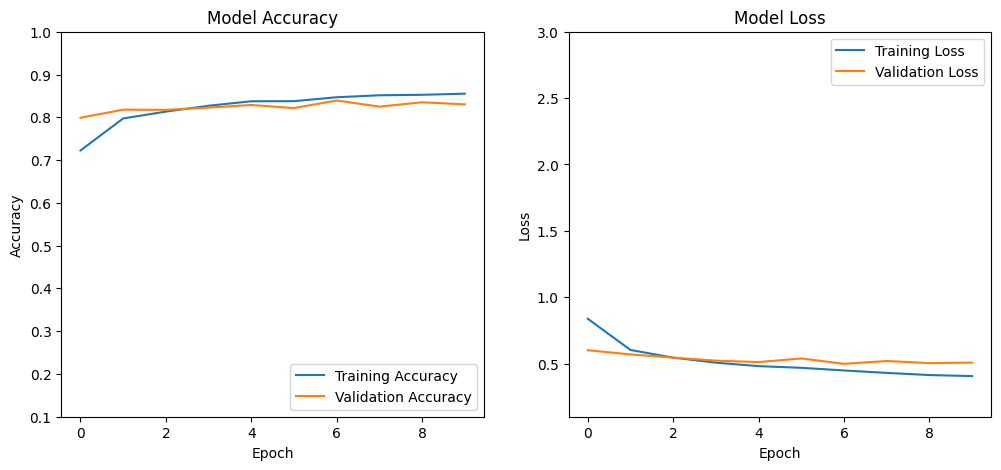

In [14]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_3['accuracy'])
plt.plot(history_3['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.1, 1)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_3['loss'])
plt.plot(history_3['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.1, 3)
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')

plt.show()

In [15]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

105/105 [==============================] - 7s 44ms/step
Classification Report
                 precision    recall  f1-score   support

          Bread       0.84      0.79      0.81       368
  Dairy product       0.79      0.68      0.73       148
        Dessert       0.79      0.82      0.80       500
            Egg       0.89      0.65      0.75       335
     Fried food       0.65      0.80      0.71       287
           Meat       0.78      0.92      0.85       432
  Noodles-Pasta       1.00      0.98      0.99       147
           Rice       0.96      0.96      0.96        96
        Seafood       0.89      0.84      0.86       303
           Soup       0.96      0.96      0.96       500
Vegetable-Fruit       0.96      0.90      0.93       231

       accuracy                           0.84      3347
      macro avg       0.86      0.84      0.85      3347
   weighted avg       0.85      0.84      0.84      3347



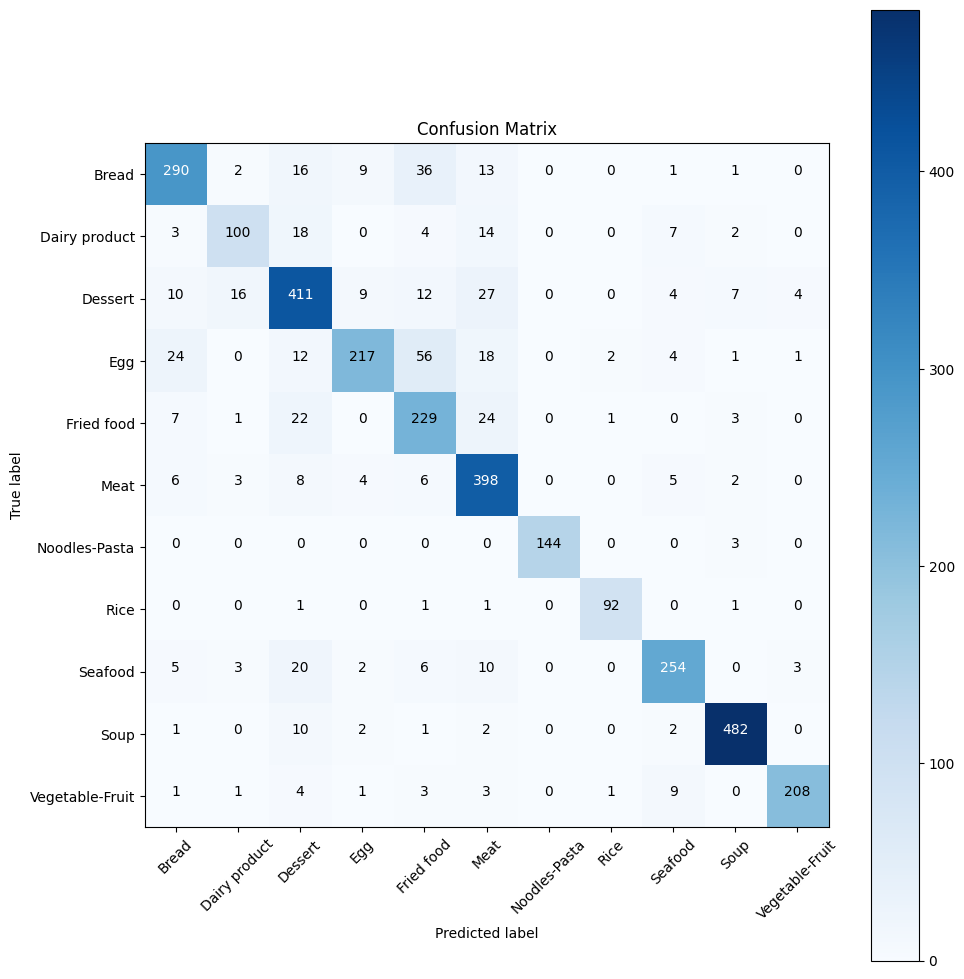

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model

#Confution Matrix and Classification Report
Y_pred = model_3.predict(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names, zero_division=1))

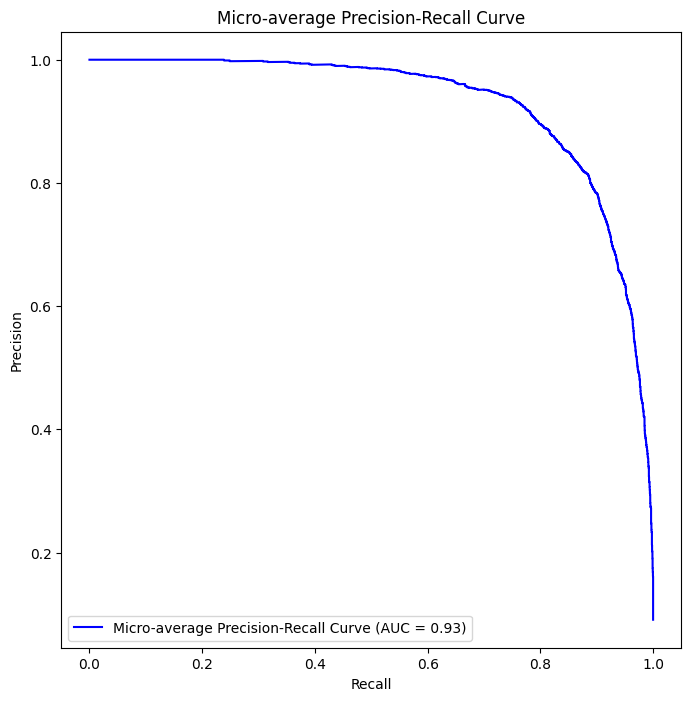

In [17]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

# Precision-Recall Curve for each class
n_classes = len(classes)
y_true_bin = label_binarize(test_generator.classes, classes=list(range(n_classes)))
precision = dict()
recall = dict()
auc_score = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], Y_pred[:, i])
    auc_score[i] = auc(recall[i], precision[i])

# Micro-average precision-recall curve and AUC
precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(), Y_pred.ravel())
auc_score["micro"] = auc(recall["micro"], precision["micro"])

# Plot micro-average Precision-Recall Curve
plt.figure(figsize=(8, 8))
plt.plot(recall["micro"], precision["micro"], label=f'Micro-average Precision-Recall Curve (AUC = {auc_score["micro"]:.2f})', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-average Precision-Recall Curve')
plt.legend()
plt.show()

In [18]:
#Generate predictions for the test dataset
y_pred = model_3.predict(test_generator)
y_pred_labels = (y_pred>0.5).astype(int)

#Get the true labels from thee test generator
y_true = test_generator.classes

105/105 [==============================] - 4s 36ms/step


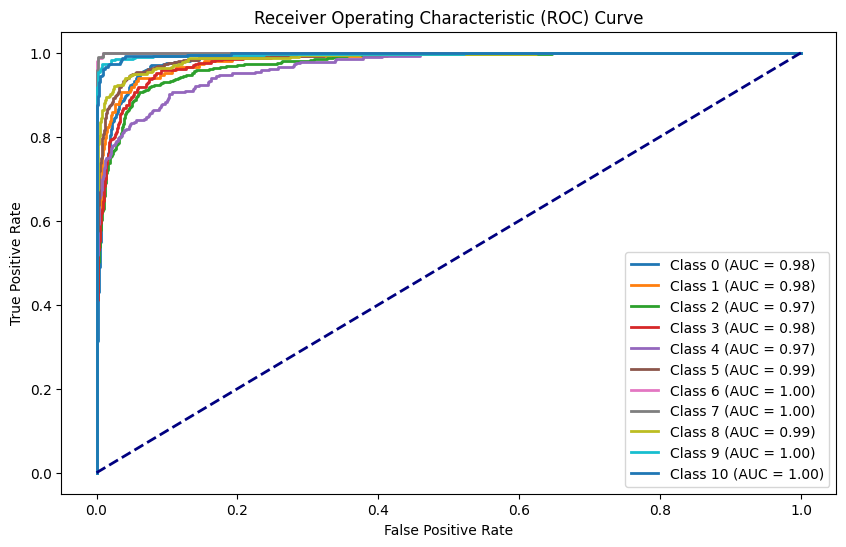

In [19]:
# Compute ROC curve
from sklearn.metrics import roc_curve, auc


#Get the true labels from thee test generator
# y_true = test_generator.classes
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Initialize arrays to store fpr, tpr, and auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()


# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [21]:
# Initialize the list of Sensitivity and Specificity for each class
sensitivity_list = []
specificity_list = []

# The Sensitivity and Specificity of each class were calculated
for i in range(len(cm)):
    tp = cm[i, i]  # True Positive
    fn = np.sum(cm[i, :]) - tp  # False Negative
    fp = np.sum(cm[:, i]) - tp  # False Positive
    tn = np.sum(cm) - (tp + fn + fp)  # True Negative
    
    sensitivity = tp / (tp + fn + 1e-10)  # Add a small number to avoid dividing by zero
    specificity = tn / (tn + fp + 1e-10)
    
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

# Output Sensitivity and Specificity for each category
for idx, (sen, spec) in enumerate(zip(sensitivity_list, specificity_list)):
    print(f"Class {idx} - Sensitivity: {sen}, Specificity: {spec}")
    
# Assuming sensitivity_list and specificity_list are already populated

# Calculate average Sensitivity and Specificity
average_sensitivity = np.mean(sensitivity_list)
average_specificity = np.mean(specificity_list)

# Output the average values
print(f"Average Sensitivity: {average_sensitivity}")
print(f"Average Specificity: {average_specificity}")

Class 0 - Sensitivity: 0.7880434782606555, Specificity: 0.9808660624370265
Class 1 - Sensitivity: 0.6756756756752192, Specificity: 0.991872460143764
Class 2 - Sensitivity: 0.8219999999998356, Specificity: 0.9610115911485437
Class 3 - Sensitivity: 0.6477611940296574, Specificity: 0.9910358565736722
Class 4 - Sensitivity: 0.7979094076652272, Specificity: 0.9591503267973542
Class 5 - Sensitivity: 0.921296296296083, Specificity: 0.9615780445968796
Class 6 - Sensitivity: 0.9795918367340276, Specificity: 0.9999999999999687
Class 7 - Sensitivity: 0.9583333333323351, Specificity: 0.9987696093509382
Class 8 - Sensitivity: 0.8382838283825617, Specificity: 0.9894875164257231
Class 9 - Sensitivity: 0.9639999999998072, Specificity: 0.9929750614681773
Class 10 - Sensitivity: 0.9004329004325107, Specificity: 0.9974326059049744
Average Sensitivity: 0.8448479955279928
Average Specificity: 0.9840162849860928


# VGG19

In [22]:
base_model = tf.keras.applications.vgg19.VGG19(
    include_top=False, 
    weights='imagenet', 
    input_shape=(250, 250, 3)
)

80134624/80134624 [==============================] - 12s 0us/step


In [23]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)


model_4 = Model(inputs=base_model.input, outputs=predictions)

In [24]:
for layer in base_model.layers:
    layer.trainable = False

In [25]:
model_4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0   

In [26]:
# Compile the model
model_4.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
history_4 = model_4.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32
)

Epoch 1/10
332/332 [==============================] - 17s 48ms/step - loss: 1.4467 - accuracy: 0.5118 - val_loss: 1.2099 - val_accuracy: 0.6013
Epoch 2/10
332/332 [==============================] - 16s 48ms/step - loss: 1.1484 - accuracy: 0.6132 - val_loss: 1.1085 - val_accuracy: 0.6231
Epoch 3/10
332/332 [==============================] - 16s 47ms/step - loss: 1.0570 - accuracy: 0.6392 - val_loss: 1.1211 - val_accuracy: 0.6103
Epoch 4/10
332/332 [==============================] - 16s 47ms/step - loss: 1.0122 - accuracy: 0.6536 - val_loss: 1.0816 - val_accuracy: 0.6242
Epoch 5/10
332/332 [==============================] - 16s 48ms/step - loss: 0.9694 - accuracy: 0.6684 - val_loss: 1.0664 - val_accuracy: 0.6352
Epoch 6/10
332/332 [==============================] - 16s 47ms/step - loss: 0.9282 - accuracy: 0.6822 - val_loss: 1.0543 - val_accuracy: 0.6502
Epoch 7/10
332/332 [==============================] - 15s 46ms/step - loss: 0.8865 - accuracy: 0.6954 - val_loss: 1.0580 - val_accuracy:

In [28]:
model_4.save('VGG19.h5')

/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
joblib.dump(history_4.history,'history_VGG19.pkl')
history_4 = joblib.load('history_VGG19.pkl')

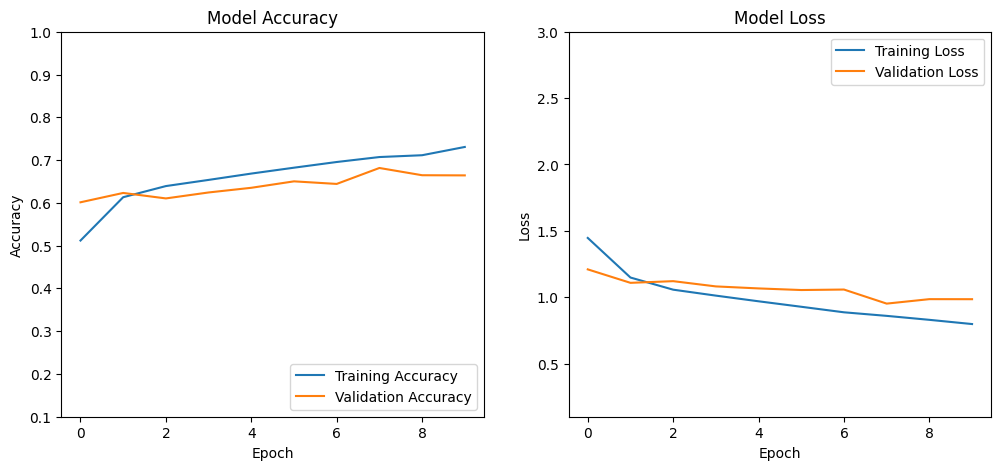

In [30]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_4['accuracy'])
plt.plot(history_4['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.1, 1)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_4['loss'])
plt.plot(history_4['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.1, 3)
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')

plt.show()

105/105 [==============================] - 4s 34ms/step
Classification Report
                 precision    recall  f1-score   support

          Bread       0.72      0.51      0.59       368
  Dairy product       0.64      0.31      0.42       148
        Dessert       0.46      0.81      0.59       500
            Egg       0.80      0.46      0.58       335
     Fried food       0.76      0.26      0.38       287
           Meat       0.65      0.81      0.72       432
  Noodles-Pasta       0.88      0.92      0.90       147
           Rice       0.82      0.84      0.83        96
        Seafood       0.72      0.71      0.71       303
           Soup       0.89      0.87      0.88       500
Vegetable-Fruit       0.76      0.86      0.80       231

       accuracy                           0.68      3347
      macro avg       0.73      0.67      0.67      3347
   weighted avg       0.72      0.68      0.67      3347



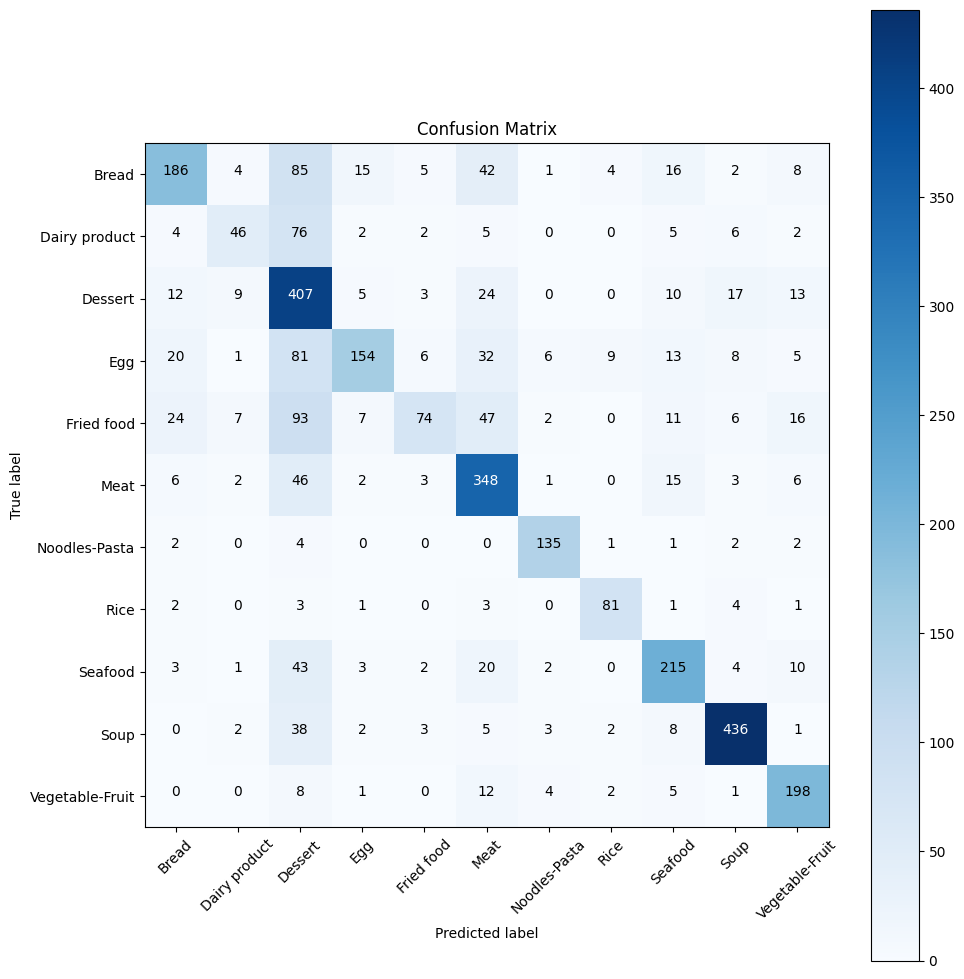

In [53]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = model_4.predict(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names, zero_division=1))

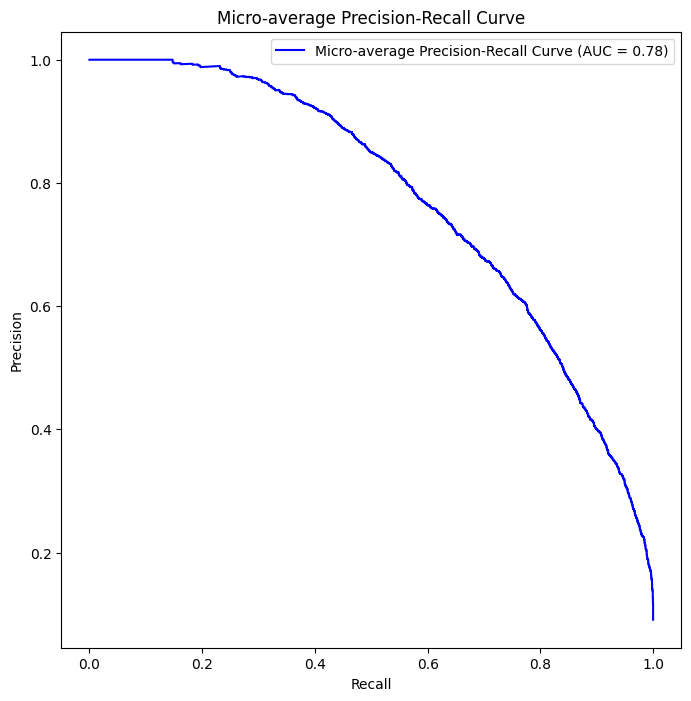

In [54]:
# Precision-Recall Curve for each class
n_classes = len(classes)
y_true_bin = label_binarize(test_generator.classes, classes=list(range(n_classes)))
precision = dict()
recall = dict()
auc_score = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], Y_pred[:, i])
    auc_score[i] = auc(recall[i], precision[i])

# Micro-average precision-recall curve and AUC
precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(), Y_pred.ravel())
auc_score["micro"] = auc(recall["micro"], precision["micro"])

# Plot micro-average Precision-Recall Curve
plt.figure(figsize=(8, 8))
plt.plot(recall["micro"], precision["micro"], label=f'Micro-average Precision-Recall Curve (AUC = {auc_score["micro"]:.2f})', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-average Precision-Recall Curve')
plt.legend()
plt.show()

In [46]:
#Generate predictions for the test dataset
y_pred = model_4.predict(test_generator)
y_pred_labels = (y_pred>0.5).astype(int)

#Get the true labels from thee test generator
y_true = test_generator.classes

105/105 [==============================] - 4s 35ms/step


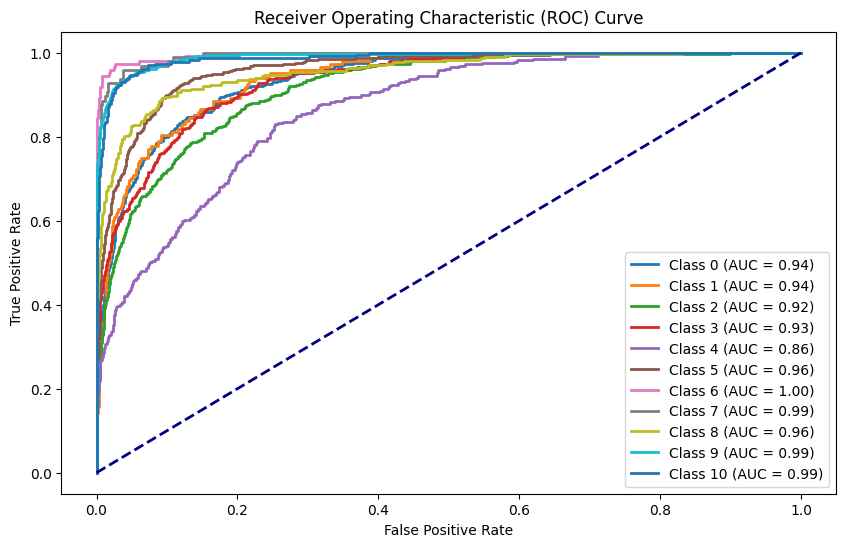

In [47]:
#Get the true labels from thee test generator
# y_true = test_generator.classes
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Initialize arrays to store fpr, tpr, and auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()


# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [48]:
# Initialize the list of Sensitivity and Specificity for each class
sensitivity_list = []
specificity_list = []

# The Sensitivity and Specificity of each class were calculated
for i in range(len(cm)):
    tp = cm[i, i]  # True Positive
    fn = np.sum(cm[i, :]) - tp  # False Negative
    fp = np.sum(cm[:, i]) - tp  # False Positive
    tn = np.sum(cm) - (tp + fn + fp)  # True Negative
    
    sensitivity = tp / (tp + fn + 1e-10)  # Add a small number to avoid dividing by zero
    specificity = tn / (tn + fp + 1e-10)
    
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

# Output Sensitivity and Specificity for each category
for idx, (sen, spec) in enumerate(zip(sensitivity_list, specificity_list)):
    print(f"Class {idx} - Sensitivity: {sen}, Specificity: {spec}")

# Calculate average Sensitivity and Specificity
average_sensitivity = np.mean(sensitivity_list)
average_specificity = np.mean(specificity_list)

# Output the average values
print(f"Average Sensitivity: {average_sensitivity}")
print(f"Average Specificity: {average_specificity}")

Class 0 - Sensitivity: 0.7336956521737137, Specificity: 0.9865726753943945
Class 1 - Sensitivity: 0.6891891891887236, Specificity: 0.994998437011535
Class 2 - Sensitivity: 0.8619999999998276, Specificity: 0.9560941341762924
Class 3 - Sensitivity: 0.7134328358206826, Specificity: 0.9870517928286525
Class 4 - Sensitivity: 0.8466898954700883, Specificity: 0.9620915032679423
Class 5 - Sensitivity: 0.879629629629426, Specificity: 0.9811320754716645
Class 6 - Sensitivity: 0.993197278910889, Specificity: 0.9978124999999688
Class 7 - Sensitivity: 0.9583333333323351, Specificity: 0.9963088280528761
Class 8 - Sensitivity: 0.8646864686465794, Specificity: 0.9931011826543694
Class 9 - Sensitivity: 0.9739999999998052, Specificity: 0.9855988760098002
Class 10 - Sensitivity: 0.9264069264065254, Specificity: 0.9971116816431002
Average Sensitivity: 0.8582964735980542
Average Specificity: 0.985261244228236


# InceptionV3 Model

In [36]:
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
], name='data_augmentation')

In [37]:
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False)
base_model.trainable =  False

# Create inputt layers
inputs = tf.keras.Input(shape=(250,250,3))

# Data augmentation
x = data_augmentation(inputs)

# Give base model input after augmentation 
x = base_model(x, training=False)

x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(11, activation='softmax')(x)

model_inception =  Model(inputs, outputs)

# Compile
model_inception.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
model_inception.summary()

87910968/87910968 [==============================] - 13s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                                 
 dropout (Dropout)           (None, None, None, 2048   0         
                             )                                   
                                                                 
 dense_3 (Dense)             (None, None, None, 1024   2098

In [38]:
#compile the model
model_inception.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
#Training
history_5 = model_inception.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=10,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/10
332/332 [==============================] - 81s 229ms/step - loss: 0.1606 - accuracy: 0.6688 - val_loss: 0.1116 - val_accuracy: 0.7624
Epoch 2/10
332/332 [==============================] - 48s 145ms/step - loss: 0.1197 - accuracy: 0.7382 - val_loss: 0.0917 - val_accuracy: 0.8061
Epoch 3/10
332/332 [==============================] - 39s 118ms/step - loss: 0.1083 - accuracy: 0.7690 - val_loss: 0.0852 - val_accuracy: 0.8261
Epoch 4/10
332/332 [==============================] - 37s 110ms/step - loss: 0.1015 - accuracy: 0.7802 - val_loss: 0.0879 - val_accuracy: 0.8174
Epoch 5/10
332/332 [==============================] - 34s 102ms/step - loss: 0.0969 - accuracy: 0.7939 - val_loss: 0.0846 - val_accuracy: 0.8268
Epoch 6/10
332/332 [==============================] - 29s 87ms/step - loss: 0.0933 - accuracy: 0.8017 - val_loss: 0.0870 - val_accuracy: 0.8204
Epoch 7/10
332/332 [==============================] - 29s 87ms/step - loss: 0.0901 - accuracy: 0.8120 - val_loss: 0.0795 - val_accu

In [40]:
model_inception.save('Inception.h5')

/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
joblib.dump(history_5.history,'history_Inception.pkl')
history_5 = joblib.load('history_Inception.pkl')

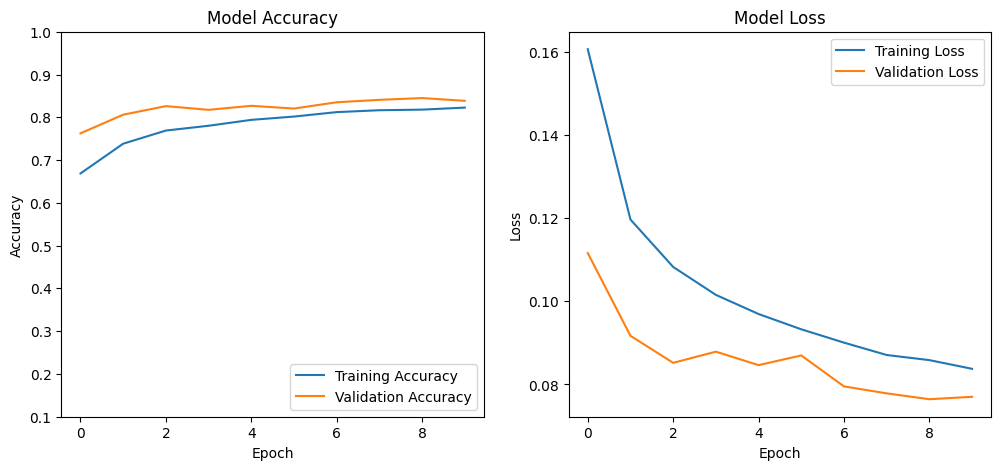

In [42]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_5['accuracy'])
plt.plot(history_5['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.1, 1)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_5['loss'])
plt.plot(history_5['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')

plt.show()

105/105 [==============================] - 5s 38ms/step
Classification Report
                 precision    recall  f1-score   support

          Bread       0.87      0.73      0.80       368
  Dairy product       0.86      0.69      0.77       148
        Dessert       0.78      0.86      0.82       500
            Egg       0.86      0.71      0.78       335
     Fried food       0.68      0.85      0.75       287
           Meat       0.87      0.88      0.88       432
  Noodles-Pasta       0.95      0.99      0.97       147
           Rice       0.88      0.96      0.92        96
        Seafood       0.93      0.86      0.89       303
           Soup       0.92      0.97      0.95       500
Vegetable-Fruit       0.96      0.93      0.94       231

       accuracy                           0.86      3347
      macro avg       0.87      0.86      0.86      3347
   weighted avg       0.86      0.86      0.86      3347



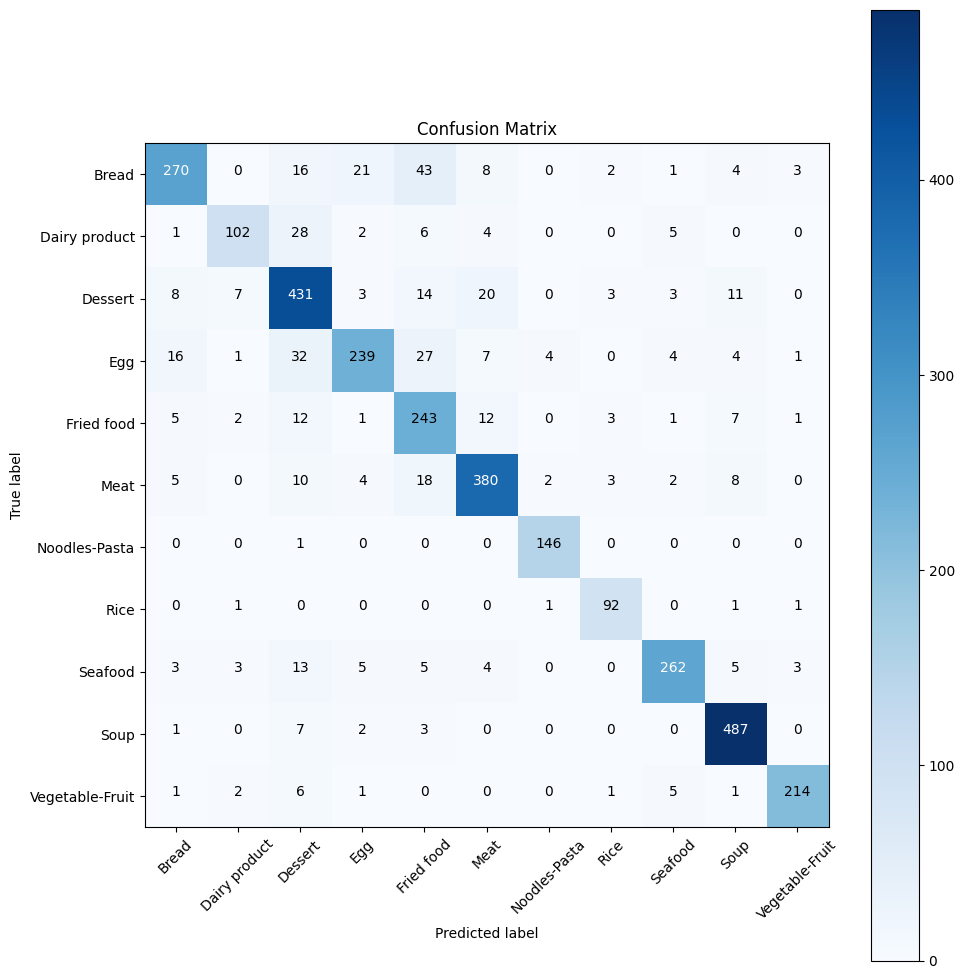

In [43]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model_inception.predict(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names, zero_division=1))

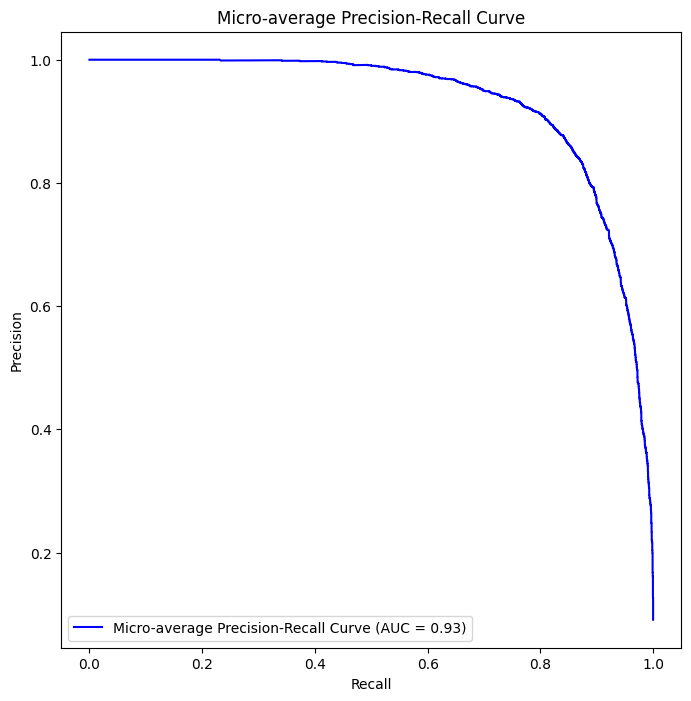

In [44]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

# Precision-Recall Curve for each class
n_classes = len(classes)
y_true_bin = label_binarize(test_generator.classes, classes=list(range(n_classes)))
precision = dict()
recall = dict()
auc_score = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], Y_pred[:, i])
    auc_score[i] = auc(recall[i], precision[i])

# Micro-average precision-recall curve and AUC
precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(), Y_pred.ravel())
auc_score["micro"] = auc(recall["micro"], precision["micro"])

# Plot micro-average Precision-Recall Curve
plt.figure(figsize=(8, 8))
plt.plot(recall["micro"], precision["micro"], label=f'Micro-average Precision-Recall Curve (AUC = {auc_score["micro"]:.2f})', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-average Precision-Recall Curve')
plt.legend()
plt.show()

In [50]:
#Generate predictions for the test dataset
y_pred = model_inception.predict(test_generator)
y_pred_labels = (y_pred>0.5).astype(int)

#Get the true labels from thee test generator
y_true = test_generator.classes

105/105 [==============================] - 4s 35ms/step


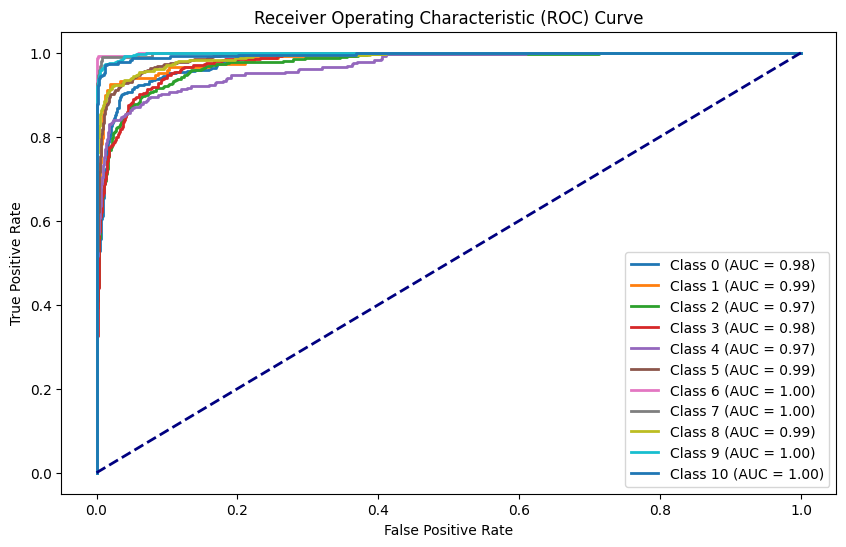

In [51]:
#Get the true labels from thee test generator
# y_true = test_generator.classes
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Initialize arrays to store fpr, tpr, and auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()


# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [52]:
# Initialize the list of Sensitivity and Specificity for each class
sensitivity_list = []
specificity_list = []

# The Sensitivity and Specificity of each class were calculated
for i in range(len(cm)):
    tp = cm[i, i]  # True Positive
    fn = np.sum(cm[i, :]) - tp  # False Negative
    fp = np.sum(cm[:, i]) - tp  # False Positive
    tn = np.sum(cm) - (tp + fn + fp)  # True Negative
    
    sensitivity = tp / (tp + fn + 1e-10)  # Add a small number to avoid dividing by zero
    specificity = tn / (tn + fp + 1e-10)
    
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

# Output Sensitivity and Specificity for each category
for idx, (sen, spec) in enumerate(zip(sensitivity_list, specificity_list)):
    print(f"Class {idx} - Sensitivity: {sen}, Specificity: {spec}")

# Calculate average Sensitivity and Specificity
average_sensitivity = np.mean(sensitivity_list)
average_specificity = np.mean(specificity_list)

# Output the average values
print(f"Average Sensitivity: {average_sensitivity}")
print(f"Average Specificity: {average_specificity}")

Class 0 - Sensitivity: 0.7336956521737137, Specificity: 0.9865726753943945
Class 1 - Sensitivity: 0.6891891891887236, Specificity: 0.994998437011535
Class 2 - Sensitivity: 0.8619999999998276, Specificity: 0.9560941341762924
Class 3 - Sensitivity: 0.7134328358206826, Specificity: 0.9870517928286525
Class 4 - Sensitivity: 0.8466898954700883, Specificity: 0.9620915032679423
Class 5 - Sensitivity: 0.879629629629426, Specificity: 0.9811320754716645
Class 6 - Sensitivity: 0.993197278910889, Specificity: 0.9978124999999688
Class 7 - Sensitivity: 0.9583333333323351, Specificity: 0.9963088280528761
Class 8 - Sensitivity: 0.8646864686465794, Specificity: 0.9931011826543694
Class 9 - Sensitivity: 0.9739999999998052, Specificity: 0.9855988760098002
Class 10 - Sensitivity: 0.9264069264065254, Specificity: 0.9971116816431002
Average Sensitivity: 0.8582964735980542
Average Specificity: 0.985261244228236


# Compare the Accuarcy of the pre-traine models

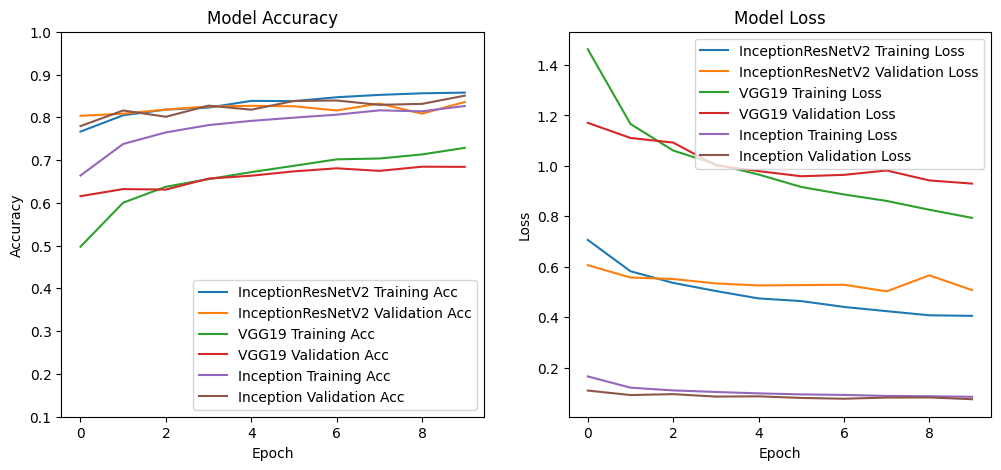

In [39]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(12, 5))

# history_ensemble = joblib.load('history3.pkl')

plt.subplot(1, 2, 1)
plt.plot(history_3['accuracy'])
plt.plot(history_3['val_accuracy'])
plt.plot(history_4['accuracy'])
plt.plot(history_4['val_accuracy'])
plt.plot(history_5['accuracy'])
plt.plot(history_5['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.1, 1)
plt.legend(['InceptionResNetV2 Training Acc', 'InceptionResNetV2 Validation Acc', 'VGG19 Training Acc', 'VGG19 Validation Acc','Inception Training Acc', 'Inception Validation Acc'], loc ='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_3['loss'])
plt.plot(history_3['val_loss'])
plt.plot(history_4['loss'])
plt.plot(history_4['val_loss'])
plt.plot(history_5['loss'])
plt.plot(history_5['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['InceptionResNetV2 Training Loss', 'InceptionResNetV2 Validation Loss', 'VGG19 Training Loss', 'VGG19 Validation Loss','Inception Training Loss', 'Inception Validation Loss'], loc ='upper right')

plt.show()

In [20]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

del model



In [21]:
#You need to install numba using 'pip install numba'

from numba import cuda

cuda.select_device(0)
cuda.close()